## Финальный проект.

### Вариант 1.

***Выполнен: студенткой 53DA — Сулеймановой Гульнар.***

### Задачи:

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

***1.*** В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

***2.*** Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

***3.*** Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

#### Импорт библиотек для работы:

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pingouin as pg
import scipy.stats as sps
from scipy.stats import levene
%matplotlib inline

### Задание 1.

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

***Retention*** — это метрика, отвечающая на вопрос, сколько людей вернулись в день Х (неделю Х, месяц Х) после первого входа в продукт. Измеряется в процентах, то есть показывает долю вернувшихся людей от изначально пришедших.

#### Данные для задачи:

- reg_data.csv – данные о времени регистрации

- auth_data.csv – данные о времени захода пользователей в игру

### 1.1 Предварительный анализ данных (EDA).

In [2]:
# Выгружаем данные.
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';') 

***Первый датафрейм reg_data.csv — данные о времени регистрации.***

In [3]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Колонка с айдишниками в числовом формате нам подходит.

Колонка ***reg_ts*** содержит дату, которая сейчас выражена числовым значением. Приведем ее к нужному типу:

In [66]:
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.normalize()

In [6]:
# Проверяем:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

Посмотрим на кол-во уникальных значений:

In [7]:
reg_data.nunique()

reg_ts       5110
uid       1000000
dtype: int64

Проверим наличие пустых значений:

In [8]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

И дубликатов:

In [9]:
reg_data.duplicated().sum()

0

***Второй датафрейм auth_data.csv – данные о времени захода пользователей в игру.***

In [10]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [11]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Как и в первом датафрейме, меняем тип данных для колонки с датой:

In [67]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.normalize()

In [13]:
# Проверяем:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

Посмотрим на кол-во уникальных значений:

In [14]:
auth_data.nunique()

auth_ts       6169
uid        1000000
dtype: int64

Проверим наличие пустых значений:

In [15]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

И дубликатов:

In [16]:
auth_data.duplicated().sum()

0

Видим, что несмотря на то, что в auth_data — 9601012 строк, уникальные значения айди пользователей совпадают по количеству в обоих датафреймах.

In [17]:
[reg_data.uid.nunique(), auth_data.uid.nunique()]

[1000000, 1000000]

***Объединим данные в общий датафрейм full_data и проверим, что объединение прошло корректно:***

In [18]:
full_data = reg_data.merge(auth_data, how='left', on='uid')

In [19]:
full_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [20]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   reg_ts   datetime64[ns]
 1   uid      int64         
 2   auth_ts  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 293.0 MB


С типами данных все в порядке.

Проверим, не потерялись ли какие-то значения:

In [21]:
full_data.isna().sum()

reg_ts     0
uid        0
auth_ts    0
dtype: int64

Проверим, есть ли пользователи, у которых первый заход в игру был ***раньше регистрации***:

In [22]:
full_data.query('auth_ts < reg_ts')

,reg_ts,uid,auth_ts


***Итак, все в порядке:***

- Типы данных соответствуют значениям в столбцах.
- Пропущенных значений и дубликатов нет.
- Так же, проверка дат показала, что в игру могут зайти ***только зарегистрированные пользователи***.

Приступаем к задаче.

### 1.2 Напишем функцию для расчета Retention.

Посмотрим, за какой период у нас есть данные:

In [23]:
min_date = full_data.reg_ts.dt.date.min()
max_date = full_data.reg_ts.dt.date.max()

print(f'[{min_date}, {max_date}]')

[1998-11-18, 2020-09-23]


In [24]:
def calculate_retention(registration_df, auth_df, start_date, end_date):
    """
    Функция принимает на вход следующие параметры:  
    
        registration_df - датафрейм с датами регистрации игроков
        auth_df         - датафрейм с датами захода пользователей в игру
        start_date      - дата начала периода в формате год-месяц-число
        end_date        - конечная дата периода в формате год-месяц-число
                        
    Возвращает:                
        Тепловую карту с retention за указанный период для игроков, которые объединяются в когорты по дате регистрации.
        В случае, если введена не корректная дата начала или конца периода, функция сообщит об этом.
    """
    
    # Преобразуем даты в формат datetime
    registration_df['reg_ts'] = pd.to_datetime(registration_df['reg_ts'], unit='s').dt.normalize()
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.normalize()
    
    # Преобразуем start_date и end_date в формат datetime, что бы они корректно сравнивались при проверке 
    start_date = pd.to_datetime(start_date).normalize()
    end_date = pd.to_datetime(end_date).normalize()

    # Проверка на корректность введенных дат
    # Осознаю, что это замедляет работу кода, и на очень больших данных не использовала бы
    # Но считаю добавление проверки целесообразным в рамках финального (учебного) проекта
    # как способ показать, чему научили. 
    if start_date not in registration_df['reg_ts'].values:
        print("Нет пользователей, зарегистрированных в указанную дату начала периода.")
        return
    if end_date not in auth_df['auth_ts'].values:
        print("Нет пользователей, заходивших в игру в указанную дату окончания периода.")
        return

    # Фильтруем данные по заданному периоду
    registration_df = registration_df[(registration_df['reg_ts'] >= start_date) & (registration_df['reg_ts'] <= end_date)]
    auth_df = auth_df[(auth_df['auth_ts'] >= start_date) & (auth_df['auth_ts'] <= end_date)]
   

    # Создаем когорты по дате регистрации
    registration_df['cohort'] = registration_df['reg_ts'].dt.to_period('D')

    # Объединяем данные о регистрации и заходе в игру
    retention_df = registration_df.merge(auth_df, on='uid', how='left')

    # Рассчитываем количество дней с даты регистрации до даты захода в игру
    retention_df['days_to_auth'] = (retention_df['auth_ts'] - retention_df['reg_ts']).dt.days

    # Считаем количество пользователей, которые вернулись в игру
    retention_counts = retention_df.groupby(['cohort', 'days_to_auth'])['uid'].nunique().reset_index()
    retention_counts.columns = ['cohort', 'days_to_auth', 'retained_users']

    # Получаем количество пользователей в каждой когорте
    cohort_sizes = registration_df.groupby('cohort')['uid'].nunique().reset_index()
    cohort_sizes.columns = ['cohort', 'cohort_size']

    # Объединяем с размерами когорт
    retention_matrix = retention_counts.merge(cohort_sizes, on='cohort')

    # Рассчитываем Retention
    retention_matrix['retention'] = retention_matrix['retained_users'] / retention_matrix['cohort_size'] * 100

    # Преобразуем данные в pivot для heatmap
    retention_pivot = retention_matrix.pivot('cohort', 'days_to_auth', 'retention')

    # Заполняем NaN значениями 0
    retention_pivot = retention_pivot.fillna(0)

    # Убираем неинформативный столбец со 100% Retention
    retention_pivot = retention_pivot.iloc[:, 1:]

    # Округляем значения до целого
    retention_pivot_rounded = retention_pivot.round(0).astype(int)

    # Создаем маску для нулевых значений, что бы убрать их из heatmap
    mask = retention_pivot == 0

    # Визуализируем Retention в виде heatmap
    plt.figure(figsize=(12, 8))
    # Выбираем палитру "viridis", так как она хорошо воспринимается людьми с различными нарушениями цветового восприятия
    ax = sns.heatmap(retention_pivot, annot=retention_pivot_rounded.astype(str) + '%', fmt='', cmap="viridis", 
                     cbar_kws={'label': 'Retention (%)'}, mask=mask)
    
    plt.title('User Retention Heatmap')
    plt.xlabel('Days to Auth')
    plt.ylabel('Cohort')
    plt.show()

### Проверяем работу фунции:

In [25]:
# Выгружаем датафреймы
registration_df = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
auth_df = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';') 

In [26]:
# Смотрим документацию к функции
print(calculate_retention.__doc__)


    Функция принимает на вход следующие параметры:  
    
        registration_df - датафрейм с датами регистрации игроков
        auth_df         - датафрейм с датами захода пользователей в игру
        start_date      - дата начала периода в формате год-месяц-число
        end_date        - конечная дата периода в формате год-месяц-число
                        
    Возвращает:                
        Тепловую карту с retention за указанный период для игроков, которые объединяются в когорты по дате регистрации.
        В случае, если введена не корректная дата начала или конца периода, функция сообщит об этом.
    


Retention для периода в две недели:

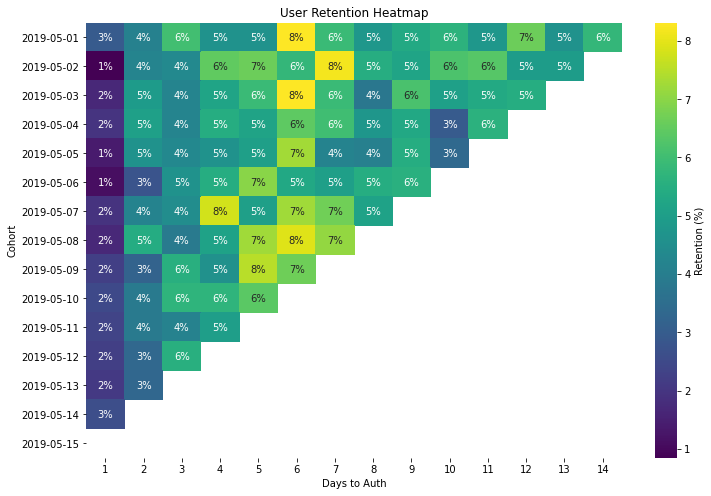

In [27]:
calculate_retention(registration_df, auth_df, '2019-05-01', '2019-05-15')

Retention для периода в месяц:

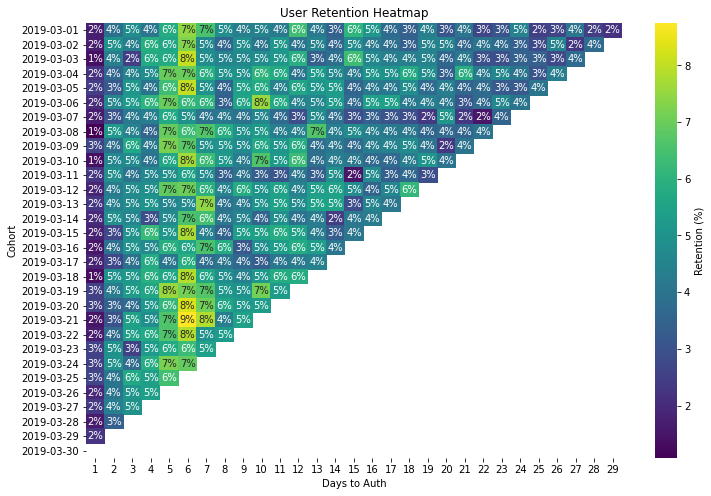

In [28]:
calculate_retention(registration_df, auth_df, '2019-03-01', '2019-03-30')

В случае, если введены неккоректные даты:

In [29]:
calculate_retention(registration_df, auth_df, '2029-10-05', '2019-05-15')

Нет пользователей, зарегистрированных в указанную дату начала периода.


In [30]:
calculate_retention(registration_df, auth_df, '2020-06-02', '2024-10-05')

Нет пользователей, заходивших в игру в указанную дату окончания периода.


### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### 2.1 Предварительный анализ данных (EDA).

In [31]:
# Выгружаем данные
ab_df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';')
ab_df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [32]:
ab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Типы данных соответствуют значениям в столбцах.

Проверим кол-во пустых значений:

In [33]:
ab_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Пустые значения отсутствуют.

Проверим наличие дубликатов:

In [34]:
ab_df.duplicated().sum()

0

Проверим кол-во уникальных значений:

In [35]:
ab_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

По условию задачи мы знаем, что групп было две. Все ок.

Так же мы знаем, что пользователей в группах a и b было 202103 и 202667 соответственно. Т.е всего 404770. Все верно.

В колонке с выручкой у нас подсчитаны только уникальные значения, поэтому их всего 1477.

Посмотрим на описательную статистику колонки с выручкой от платящих пользователей:

In [36]:
ab_df.query('revenue > 0').revenue.describe()

count     3733.000000
mean      2828.232521
std       6516.770722
min        200.000000
25%        309.000000
50%       2052.000000
75%       3126.000000
max      37433.000000
Name: revenue, dtype: float64

В условии в группах a и b указаны 1928 и 1805 платящих пользователей соответственно. В сумме 3733, что мы и видим.

Стандартное отклонение огромное, но с этим разберемся чуть позже.

Посмотрим, совпадают ли данные о платящих пользователях в группах с указанными в условии задачи. 

***Для контрольной группы(а) - 1928***

***Для тестовой группы(b) - 1805***

In [37]:
ab_df.query('revenue > 0').groupby('testgroup', as_index=False).agg({'user_id' : 'nunique'})

,testgroup,user_id
0,a,1928
1,b,1805


Для удобства восприятия дадим группам a и b содержательные названия test и control:

In [38]:
ab_df['testgroup']= ab_df['testgroup'].replace({'a': 'control', 'b': 'test'})

Посмотрим на описательную статистику выручки в разрезе групп:

In [39]:
ab_df.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,202103.0,25.413720,920.768137,0.0,0.0,0.0,0.0,37433.0
test,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Видим, что:

Тестовая группа чуть больше, нежели контрольная.

Стандартное отклонение в контрольной группе в 3 раза превышает его же в тестовой. И в целом, большая разница между средним и std говорит о том, что у нас очень большой разброс значений в данных.

Максимальное значение в контрольной группе почти в 10 раз больше, чем в тестовой.

Среднее значение в тестовой группе больше:

In [40]:
# Вычислим разницу между средними:
test_mean = 26.751287
control_mean = 25.413720
diff = test_mean - control_mean 
# Вычислим разницу в %
diff_percent = round((diff / control_mean) * 100)
print(f'В тестовой группе среднее значение больше на {diff_percent}%, чем в контрольной.')

В тестовой группе среднее значение больше на 5%, чем в контрольной.


Собственно, в условии задачи это было заявлено (ARPU в тестовой группе выше на 5%), но мы убедились еще раз.

Тогда посмотрим на платящих пользователей:

In [41]:
# Выведем описательную статистику для платящих пользователей
ab_df.query('revenue > 0').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Видим, что:

Платящих пользователей в контрольной группе больше. 

А дальше происходит что-то непонятное. Средний чек в тестовой группе на 12% больше, нежели в контрольной. Но при этом разброс значений от минимального к максимальному в контрольной группе огромный, тогда как в тестовой все более или менее равномерно. 

Визуализируем для наглядности:

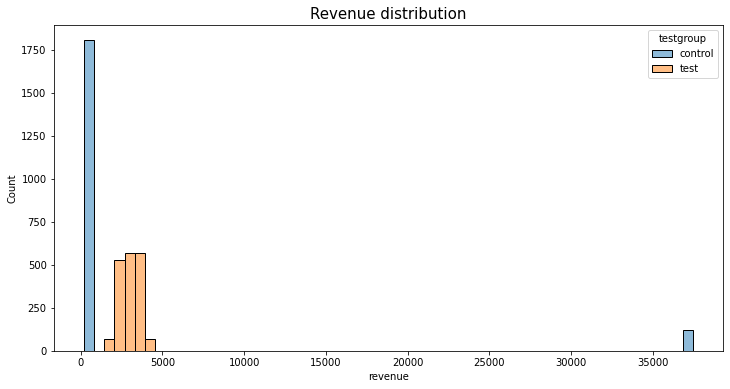

In [42]:
# Для удобства восприятия,расположим распределения выручки в группах на одном графике.
plt.figure(figsize = (12,6))
sns.histplot(ab_df.query('revenue > 0'), x = 'revenue', hue = 'testgroup', bins = 60)
plt.title('Revenue distribution', fontsize = 15)
plt.show()

На графике видно, что в контрольной группе есть пользователи, которые сделали очень дорогие заказы. Посмотрим на общую картину, если исключить их из статистики:

In [43]:
ab_df.query('revenue > 0 and revenue < 35000').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1805.0,302.458172,57.914246,200.0,254.0,305.0,352.0,400.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Что мы имеем теперь:

Кол-во пользователей в группах сравнялось, а все показатели тестовой группы в 10 раз больше, чем в контрольной.


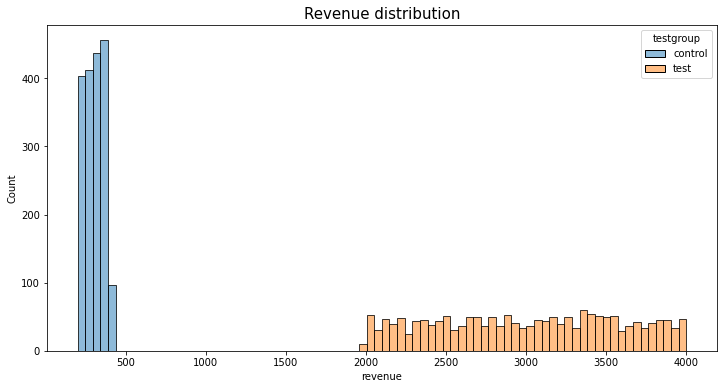

In [44]:
plt.figure(figsize = (12,6))
sns.histplot(ab_df.query('revenue > 0 and revenue < 35000'), x = 'revenue', hue = 'testgroup', bins = 80)
plt.title('Revenue distribution', fontsize = 15)
plt.show()

Но какое влияние на выручку в контрольной группе оказали те 123 пользователя, которых мы отсеяли:

In [45]:
# Отфильтруем контрольную группу платящих клиентов в отдельный датафрейм
control_group = ab_df.query('revenue > 0 and testgroup == "control"')

In [46]:
# Общая выручка и кол-во пользователей в контрольной группе:
total_revenue = control_group.revenue.sum()
users_count = control_group.user_id.nunique()
# И выручка пользователей с дорогими покупками:
profitable_users_count = control_group.query('revenue > 500').user_id.nunique()
profitable_users_revenue = control_group.query('revenue > 500').revenue.sum()

percent_of_clients = round((profitable_users_count / users_count) * 100)
revenue_impact = round((profitable_users_revenue / total_revenue) * 100)

print(f'Доля высокодоходных клиентов от общего числа составляет {percent_of_clients}%\nА их вклад в общую выручку - {revenue_impact}%')

Доля высокодоходных клиентов от общего числа составляет 6%
А их вклад в общую выручку - 89%


Выглядит это все очень странно, и у меня есть две теории появления такой разницы в данных:

***1. A/B тестирование было проведено неправильно.***

Точнее, игроки были неккоректно распределены по группам. В контрольную группу попало 1805 человек, которые готовы платить - но мало (чек до 500), и 123 человека, которые готовы были заплатить много(более 35000). Разрыв огромный.

В тоже время в тестовой группе такого четкого разделения платежеспособности не наблюдается. Для 1805 платящих игроков выручка распределена достаточно равномерно(от 2000 до 4000). 

Исходя из своего здравого смысла, я сомневаюсь, что такое деление на группы может быть умышленным. Оно даже на бумаге выглядит неинформативным, потому что сравнивать настолько непересекающиеся по платежеспособности группы не имеет смысла. Ведь одним из важнейших факторов при формировании контрольной и тестовой групп является их сходство по характеристикам(например, демографическим данным, поведению, предыдущему опыту и т.д.). Это помогает убедиться, что любые различия в результатах можно объяснить только тестируемым фактором. 

В нашем случае, очевидно, что о схожести в ключевом показателе - платежеспособности(судя по имеющимся данным) - речи не идет, и эксперемент следует проводить повторно с корректированием групп.

***2. Но у меня есть вторая теория.***

Что случилось с данными, когда мы исключили 123 пользователя с большим чеком?

Напомню:

In [47]:
ab_df.query('revenue > 0 and revenue < 35000').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1805.0,302.458172,57.914246,200.0,254.0,305.0,352.0,400.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Я смотрю на эти данные, и вижу в них похожесть. И это породило мою теорию:

А что, если данные просто неправильно записались? Посмотрите на минимальный и максимальный чеки. Разница между группами РОВНО в 10 раз. Да и остальные показатели похожи. Вдруг для 1805 пользователей выручка записалась в 10 раз меньше? А для 123 человек в 10 раз больше?

Раз уж это финальный проект, и на протяжении курса нас поощряли к самостоятельности и проявлению себя, пожалуй, я проверю эту теорию.

In [48]:
# Создам датафрейм для своего эксперемента.
experiment = ab_df.copy()

In [49]:
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Теперь отредактирую значения в колонке revenue для контрольной группы. Маленький чек увеличу в 10 раз, большой чек уменьшу в 10 раз.

In [50]:
experiment.loc[experiment['testgroup'] == 'control', 'revenue'] = experiment.loc[experiment['testgroup'] == 'control', 'revenue'] \
          .apply(lambda x: 0 if x == 0 else (round(x * 10) if x < 500 else round(x / 10)))

И что у нас вышло? 

Статистика по выручке для всех пользователей:

In [51]:
experiment.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,202103.0,29.284063,303.834473,0.0,0.0,0.0,0.0,4000.0
test,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


Средний чек теперь больше в контрольной группе. Стандартное отклонение +- выровнялось. Максимальный чек одинаковый.

Посмотрим, как дела обстоят у платящих пользователей:

In [52]:
experiment.query('revenue > 0').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1928.0,3069.707988,586.426872,2000.0,2570.0,3110.0,3610.0,4000.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Что ж, теперь статистические показатели выручки в группах имеют ***незначительные*** отличия. 
И их мы можем объяснить только тестируемым фактором. 

Визуализируем распределения выручки по группам:

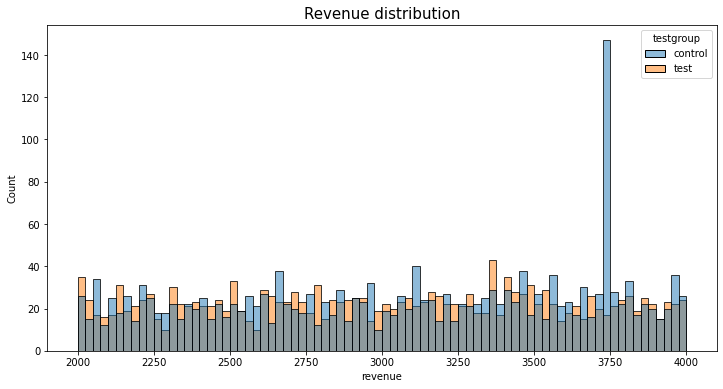

In [53]:
# На одном графике:
plt.figure(figsize = (12,6))
sns.histplot(experiment.query('revenue > 0'), x = 'revenue', hue = 'testgroup', bins = 80)
plt.title('Revenue distribution', fontsize = 15)
plt.show()

На графике мы видим, что теперь группы пересекаются.

В целом, все достаточно ровно, но есть всплеск в контрольной группе у значения 3750. Посмотрим, что там:

In [54]:
# Сколько пользователей в нужном диапазоне
experiment.query('testgroup == "control" and revenue > 3725 and revenue < 3750').user_id.count()

147

In [55]:
# Какую выручку они принесли контрольной группе
experiment.query('testgroup == "control" and revenue > 3725 and revenue < 3750').revenue.sum()

548657

Как мы видим, почти на каждый промежуток цен приходится от 20 до 40 пользователей. 
И только предложения в диапозоне от 3725 до 3750 вызвали повышенный спрос у контрольной группы. 147 человек потратили 548 тысяч.

Посмотрим на выручку в группах в целом:

In [56]:
experiment.groupby('testgroup')['revenue'].sum()

testgroup
control    5918397
test       5421603
Name: revenue, dtype: int64

И на медианные значения выручки в группах:

In [57]:
experiment.query('revenue > 0').groupby('testgroup')['revenue'].median()

testgroup
control    3110
test       3022
Name: revenue, dtype: int64

#### Наконец-то выводы к анализу данных:

- Типы данных соответствуют значениям в столбцах.
- Пропущенные значиния и дубликаты отсутствуют.
- Наблюдаются аномалии в контрольной группе. Либо данные неправильно записаны, либо АБ тестирование проводилось на неккоректно сформированных группах.

С учетом всего вышесказанного, я моделирую ситуацию, при которой я уточнила этот момент, и оказалось, что группы были сформированы правильно, и ошибка действительно была допущена при записи данных контрольной группы.

Поэтому статистические тесты проведу на исправленном мной датафрейме.

### 2.2 Решение задачи.

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Что бы оценить, как новые акционные предложения повлияли на доход и кол-во платящих пользователей, я буду использовать следующие метрики:
    
***ARPU (Average revenue per user)*** - средний доход с привлечённого пользователя.

***ARPPU (Average Revenue Per Paying User)*** — средний доход, получаемый от каждого платящего пользователя. 

***Конверсия(CR)*** - метрика, которая измеряет процент пользователей, совершивших покупку.

In [58]:
experiment.groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,202103.0,29.284063,303.834473,0.0,0.0,0.0,0.0,4000.0
test,202667.0,26.751287,287.324162,0.0,0.0,0.0,0.0,4000.0


In [59]:
experiment.query('revenue > 0').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
control,1928.0,3069.707988,586.426872,2000.0,2570.0,3110.0,3610.0,4000.0
test,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Из статистики мы видим, что:
    
- Средний чек на всех пользователей меньше в тестовой группе.
- Средний чек платящих пользователей меньше в тестовой группе.
- И кол-во платящих пользователей меньше в тестовой группе.

Проверим, насколько эти показатели статистически значимы.

Для сравнения средних значений (ARPU, ARPPU) двух групп я буду использовать t-test. 

Центральная пределеная теорема говорит нам о том, что при достаточном размере выборки распределение выборочных средних будет стремиться к нормальному распределению, независимо от формы распределения исходной популяции. Поэтому нам нужно проверить данные на гомоскедастичность (равенство дисперсий), что бы определиться с критерием для t-теста.


***Проведем тест Левена:***

Гипотезы:

$H_0$: Дисперсии в группах равны

$H_1$: Дисперсии в группах не равны

при уровне значимости 5%

In [60]:
c_group = experiment.query('testgroup == "control"')
t_group = experiment.query('testgroup == "test"')

In [61]:
statistic, p_value = levene(c_group['revenue'], t_group['revenue'])

if p_value > 0.05:
    print("Дисперсии в группах равны, p-value > 0.05")
else:
    print("Отвергаем нулевую гипотезу о равенстве дисперсий, p-value < 0.05")

Отвергаем нулевую гипотезу о равенстве дисперсий, p-value < 0.05


Так как дисперсии не равны, для проведения t-теста будем использовать t-критерий Уэлча (в модуле pingouin он заложен по умолчанию). 


***ARPU***

Гипотезы:

$H_0$: ARPU в контрольной и тестовой группах не отличается

$H_1$: ARPU в контрольной и тестовой группах отличается

при уровне значимости 5%.

In [62]:
pg.ttest(experiment.query('testgroup == "control"').revenue, 
         experiment.query('testgroup == "test"').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.724648,403382.973348,two-sided,0.006437,"[0.71, 4.35]",0.008566,0.145,0.777833


p-value < 0.05, что говорит нам о том, что ARPU в контрольной и тестовой группах значимо отличается.

***ARPPU***

Гипотезы:

$H_0$: ARPPU в контрольной и тестовой группах не отличается

$H_1$: ARPPU в контрольной и тестовой группах отличается

при уровне значимости 5%.

In [63]:
pg.ttest(experiment.query('testgroup == "control" & revenue > 0').revenue, 
         experiment.query('testgroup == "test"  & revenue > 0').revenue)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.480996,3724.391067,two-sided,0.000505,"[28.85, 103.25]",0.11392,15.257,0.935418


p-value < 0.05, что говорит нам о том, что ARPPU в контрольной и тестовой группах значимо отличается.

Так как ***конверсия(CR)*** - это категориальная переменная, для проверки я буду использовать критерий хи-квадрат.

Гипотезы:

$H_0$: Конверсия в контрольной и тестовой группах не отличается

$H_1$: Конверсия в контрольной и тестовой группах отличается

при уровне значимости 5%.

In [64]:
stat, p_value, dof, expected = sps.chi2_contingency(pd.crosstab(experiment.testgroup, experiment.revenue > 0))
print(round(p_value,3))

0.036


p-value < 0.05, что говорит нам о том, что конверсия в контрольной и тестовой группах значимо отличается.

### Вывод:

Итак, проведенные тесты показали, что измеряемые метрики (ARPU, ARPPU, CR) статистически значимо ухудшились в тестовой группе. Из чего можно сделать вывод, что ***старые акционные предложения работают лучше***, а от новых следует отказаться.

### Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 


***3.1 С помощью каких метрик можно оценить результаты последнего прошедшего события?***

Для оценки прошедшего события имеет смысл выделить:

#### Метрики продукта - они помогают оценить качество и эффективность самого игрового процесса, а также взаимодействие игроков с игрой. Для нашей задачи я бы использовала:

***Количество участников события***:

Высокое количество участников события может свидетельствовать о том, что оно привлекло внимание игроков и вызвало интерес.

***Процент завершения уровней***:

Процент завершения уровней помогает определить, насколько уровни сбалансированы по сложности. 
Если процент завершения слишком низкий, это может указывать на то, что уровни слишком сложные или фрустрирующие(т.е. вызывают чувства разочарования, раздражения, бессилия) для игроков.
Высокий же процент завершения уровней может свидетельствовать о том, что игроки заинтересованы в контенте и находят его увлекательным. Так же высокий показатель данной метрики может говорить о том, что уровни события хорошо спроектированы и соответствуют ожиданиям игроков.

***Средняя продолжительность сессии***: 

Среднее время, проведенное игроками в игре за одну сессию во время события.


***Количество полученных наград***: 

Высокое количество полученных наград может свидетельствовать о том, что событие, его дизайн и механики были привлекательными, поддержививали интерес игроков к событию и мотивировали их возвращаться в игру, что бы участвовать и завершать уровни.

***P.S.: отлично, если в игре есть обратная связь. Это очень полезная метрика для оценки продукта***:
 
Обратная связь позволяет выявить проблемы, с которыми сталкиваются игроки, будь то баги, неудобные механики или недостаток контента. Это помогает команде быстро реагировать на негативные аспекты и улучшать игру.

#### Метрики роста - они помогают оценить, как событие влияет на общие показатели бизнеса, такие как вовлеченность, удержание и доход. Для нашей задачи я бы использовала:

***Частота входа в игру***: 

Как часто игроки заходят в игру во время события по сравнению с обычным периодом.
Частота входа может напрямую влиять на доходы от внутриигровых покупок. Игроки, которые чаще входят в игру, с большей вероятностью будут совершать покупки, что может увеличить общие доходы.

***Среднее время прохождения уровней***: 

Если игроки тратят много времени на уровень, это может повлиять на их желание совершать внутриигровые покупки, такие как подсказки или ускорения. Оптимальное среднее время прохождения может способствовать увеличению доходов.
Игроки, которые успешно завершают уровни в разумные сроки, с большей вероятностью будут возвращаться в игру.

***Retention (удержание) после события***: 

Процент игроков, которые продолжили играть после завершения события, по сравнению с теми, кто не участвовал. 
Высокий уровень удержания после события может свидетельствовать о том, что игроки заинтересованы в продолжении игры и готовы возвращаться за новым контентом, рекомендовать игру другим и продолжать тратить деньги на внутриигровые покупки.

***Количество заработанных монет***: 

Заработок монет может служить важным стимулом для игроков. Если игроки видят, что они могут зарабатывать монеты, это может повысить их вовлеченность и желание продолжать играть.
Количество заработанных монет может влиять на решения игроков о совершении внутриигровых покупок. Если игроки чувствуют, что они могут легко зарабатывать монеты, они могут быть менее склонны тратить реальные деньги. Напротив, если заработок монет затруднен, игроки могут быть более открыты к покупкам, чтобы ускорить свой прогресс. Здесь важно соблюдать баланс.


***3.2 Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?***

При данных условиях, к вышеперечисленным, я бы добавила следующие метрики продукта:

 
***Среднее количество попыток на уровень***: 

Метрика поможет понять, как новая механика влияет на игровой процесс. 

***Количество откатов***: 

Метрика, которая будет отслеживать, сколько уровней игроки откатываются после неудачных попыток. 

***Процент успешных попыток***: 

Важно отслеживать, сколько попыток игроки делают, прежде чем успешно пройти уровень.
